In [106]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

from catboost import CatBoostRegressor, Pool, metrics, cv

import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

In [26]:
def result_pred(pred, resY):
    print(f'mean_squared_error: {math.sqrt(mean_squared_error(resY, pred))}')
    print(f'mean_absolute_error: {mean_absolute_error(resY, pred)}')
    print(f'median_absolute_error: {median_absolute_error(resY, pred)}')
    print(f'r2_score: {r2_score(resY, pred)}')

In [27]:
def result_value(pred, resY):
    return [math.sqrt(mean_squared_error(resY, pred)),
            mean_absolute_error(resY, pred),
            median_absolute_error(resY, pred),
            r2_score(resY, pred)]

In [28]:
def result_table(args, resY, subcol=None, valueSubCol=None):
    if subcol and valueSubCol:
        dt = {subcol: valueSubCol,
            'mean_squared_error': [],
            'mean_absolute_error': [],
            'median_absolute_error': [],
            'r2_score': []}
    else:
        dt = {'mean_squared_error': [],
            'mean_absolute_error': [],
            'median_absolute_error': [],
            'r2_score': []}
    preds = args
    for pred in preds:
        tmp = result_value(pred, resY)
        dt['mean_squared_error'].append(tmp[0])
        dt['mean_absolute_error'].append(tmp[1])
        dt['median_absolute_error'].append(tmp[2])
        dt['r2_score'].append(tmp[3])
    return dt

# **Подгрузка данных и обработка**

In [29]:
data = pd.read_csv('cars_sampled.csv')

In [30]:
data

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
0,30/03/2016 13:51,Zu_verkaufen,private,offer,4450,test,limousine,2003,manual,150,3er,150000,3,diesel,bmw,NaN,30/03/2016 0:00,20257,7/4/2016 4:44
1,7/3/2016 9:54,Volvo_XC90_2.4D_Summum,private,offer,13299,control,suv,2005,manual,163,xc_reihe,150000,6,diesel,volvo,no,7/3/2016 0:00,88045,26/03/2016 13:17
2,1/4/2016 0:57,Volkswagen_Touran,private,offer,3200,test,bus,2003,manual,101,touran,150000,11,diesel,volkswagen,NaN,31/03/2016 0:00,27449,1/4/2016 8:40
3,19/03/2016 17:50,Seat_Ibiza_1.4_16V_Reference,private,offer,4500,control,small car,2006,manual,86,ibiza,60000,12,petrol,seat,no,19/03/2016 0:00,34537,7/4/2016 4:44
4,16/03/2016 14:51,Volvo_XC90_D5_Aut._RDesign_R_Design_AWD_GSHD_S...,private,offer,18750,test,suv,2008,automatic,185,xc_reihe,150000,11,diesel,volvo,no,16/03/2016 0:00,55270,1/4/2016 23:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,3/4/2016 15:48,Suche_VW_T5_Multivan,private,request,0,test,bus,2005,NaN,0,transporter,150000,0,NaN,volkswagen,NaN,3/4/2016 0:00,29690,5/4/2016 15:16
49997,27/03/2016 14:55,Suche_einen_originalen_VW_Golf_2_Fire_and_Ice_G60,private,request,19999,control,NaN,1990,NaN,0,golf,5000,0,NaN,volkswagen,NaN,27/03/2016 0:00,50181,7/4/2016 11:45
49998,14/03/2016 18:51,[SUCHE]_BMW_e46_Coupe_330ci_M_Paket_Facelift__...,private,request,0,test,coupe,2004,manual,0,3er,150000,1,petrol,bmw,no,14/03/2016 0:00,86956,25/03/2016 6:17
49999,15/03/2016 18:06,Verkaufe_mehrere_Fahrzeuge_zum_Verschrotten,commercial,offer,100,control,station wagon,2000,manual,0,megane,150000,8,petrol,renault,NaN,15/03/2016 0:00,65232,6/4/2016 17:15


## **Убираем не заполненые ценами данные**

In [31]:
data = data[(data.price > 0) & (data.powerPS > 0)]

In [32]:
data

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
0,30/03/2016 13:51,Zu_verkaufen,private,offer,4450,test,limousine,2003,manual,150,3er,150000,3,diesel,bmw,NaN,30/03/2016 0:00,20257,7/4/2016 4:44
1,7/3/2016 9:54,Volvo_XC90_2.4D_Summum,private,offer,13299,control,suv,2005,manual,163,xc_reihe,150000,6,diesel,volvo,no,7/3/2016 0:00,88045,26/03/2016 13:17
2,1/4/2016 0:57,Volkswagen_Touran,private,offer,3200,test,bus,2003,manual,101,touran,150000,11,diesel,volkswagen,NaN,31/03/2016 0:00,27449,1/4/2016 8:40
3,19/03/2016 17:50,Seat_Ibiza_1.4_16V_Reference,private,offer,4500,control,small car,2006,manual,86,ibiza,60000,12,petrol,seat,no,19/03/2016 0:00,34537,7/4/2016 4:44
4,16/03/2016 14:51,Volvo_XC90_D5_Aut._RDesign_R_Design_AWD_GSHD_S...,private,offer,18750,test,suv,2008,automatic,185,xc_reihe,150000,11,diesel,volvo,no,16/03/2016 0:00,55270,1/4/2016 23:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49992,14/03/2016 13:57,Opel_Astra_2.0_DI_Elegance,private,offer,790,test,limousine,1998,manual,82,astra,150000,9,diesel,opel,no,14/03/2016 0:00,99310,31/03/2016 0:45
49993,14/03/2016 11:37,Renault_Clio_mit_Servolenkung_und_neuem_TÜV!,private,offer,830,test,small car,1999,manual,60,clio,125000,8,petrol,renault,no,14/03/2016 0:00,33659,22/03/2016 4:47
49994,9/3/2016 1:36,Porsche_993,private,offer,175000,control,coupe,1998,manual,286,911,50000,2,petrol,porsche,no,9/3/2016 0:00,35418,14/03/2016 23:17
49995,23/03/2016 21:45,Opel_Astra_G_Caravan__Tuev_2/2018__Scheckheft_...,private,offer,2290,test,station wagon,2001,manual,101,astra,150000,3,petrol,opel,no,23/03/2016 0:00,27305,4/4/2016 1:47


## **Ищем пустые значения по другим колонкам**

In [33]:
data.isnull().sum()

dateCrawled               0
name                      0
seller                    0
offerType                 0
price                     0
abtest                    0
vehicleType            2942
yearOfRegistration        0
gearbox                 825
powerPS                   0
model                  1753
kilometer                 0
monthOfRegistration       0
fuelType               2662
brand                     0
notRepairedDamage      6406
dateCreated               0
postalCode                0
lastSeen                  0
dtype: int64

In [34]:
data['vehicleType'].value_counts()

vehicleType
limousine        11929
small car         9440
station wagon     8200
bus               3637
cabrio            2828
coupe             2328
suv               1856
others             342
Name: count, dtype: int64

In [35]:
data['gearbox'].value_counts()

gearbox
manual       33056
automatic     9621
Name: count, dtype: int64

In [36]:
data['fuelType'].value_counts()

fuelType
petrol     26931
diesel     13084
lpg          699
cng           71
hybrid        36
electro       12
other          7
Name: count, dtype: int64

In [37]:
data['notRepairedDamage'].value_counts()

notRepairedDamage
no     33017
yes     4079
Name: count, dtype: int64

In [38]:
data['model'].value_counts()

model
golf          3530
others        2959
3er           2523
polo          1522
corsa         1418
              ... 
b_max            1
serie_3          1
elefantino       1
charade          1
rangerover       1
Name: count, Length: 247, dtype: int64

In [39]:
data['vehicleType'] = data['vehicleType'].fillna('coupe')
data['gearbox'] = data['gearbox'].fillna('manual')
data['fuelType'] = data['fuelType'].fillna('petrol')
data['notRepairedDamage'] = data['notRepairedDamage'].fillna('no')
data['model'] = data['model'].fillna('golf')

C:\Users\Egor\AppData\Local\Temp\ipykernel_3708\431619664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['vehicleType'] = data['vehicleType'].fillna('coupe')
C:\Users\Egor\AppData\Local\Temp\ipykernel_3708\431619664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gearbox'] = data['gearbox'].fillna('manual')
C:\Users\Egor\AppData\Local\Temp\ipykernel_3708\431619664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

## **Убираем не нужные колонки**

In [40]:
data[data.offerType != 'offer']

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen


In [41]:
data = data.drop(columns=['name', 'dateCrawled', 'lastSeen', 'dateCreated', 'postalCode', 'offerType', 'monthOfRegistration', 'abtest'])

In [42]:
data

,seller,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
0,private,4450,limousine,2003,manual,150,3er,150000,diesel,bmw,no
1,private,13299,suv,2005,manual,163,xc_reihe,150000,diesel,volvo,no
2,private,3200,bus,2003,manual,101,touran,150000,diesel,volkswagen,no
3,private,4500,small car,2006,manual,86,ibiza,60000,petrol,seat,no
4,private,18750,suv,2008,automatic,185,xc_reihe,150000,diesel,volvo,no
...,...,...,...,...,...,...,...,...,...,...,...
49992,private,790,limousine,1998,manual,82,astra,150000,diesel,opel,no
49993,private,830,small car,1999,manual,60,clio,125000,petrol,renault,no
49994,private,175000,coupe,1998,manual,286,911,50000,petrol,porsche,no
49995,private,2290,station wagon,2001,manual,101,astra,150000,petrol,opel,no


## **Проверка на выбросы**

**Анамальными могут оказаться колонки: price, yearOfRegistration, powerPS, kilometer их мы и будем проверять**

<Axes: xlabel='kilometer'>

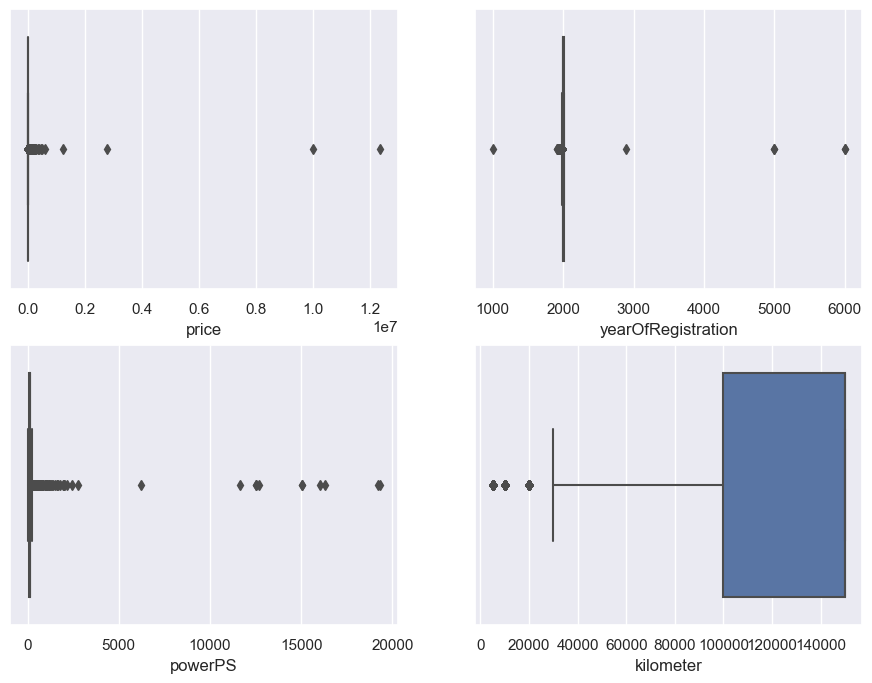

In [43]:
sns.set(rc={'figure.figsize': (11, 8)})

fig, axes = plt.subplots(2, 2)

sns.boxplot(x=data.price, ax=axes[0, 0])
sns.boxplot(x=data.yearOfRegistration, ax=axes[0, 1])
sns.boxplot(x=data.powerPS, ax=axes[1, 0])
sns.boxplot(x=data.kilometer, ax=axes[1, 1])

In [44]:
data = data[(data['yearOfRegistration'] > 1959) & (data['yearOfRegistration'] < 2023) &
      (data['powerPS'] <= 2200) & (data.price <= 300000) & (data['kilometer'] > 21000)]

In [45]:
data

,seller,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
0,private,4450,limousine,2003,manual,150,3er,150000,diesel,bmw,no
1,private,13299,suv,2005,manual,163,xc_reihe,150000,diesel,volvo,no
2,private,3200,bus,2003,manual,101,touran,150000,diesel,volkswagen,no
3,private,4500,small car,2006,manual,86,ibiza,60000,petrol,seat,no
4,private,18750,suv,2008,automatic,185,xc_reihe,150000,diesel,volvo,no
...,...,...,...,...,...,...,...,...,...,...,...
49992,private,790,limousine,1998,manual,82,astra,150000,diesel,opel,no
49993,private,830,small car,1999,manual,60,clio,125000,petrol,renault,no
49994,private,175000,coupe,1998,manual,286,911,50000,petrol,porsche,no
49995,private,2290,station wagon,2001,manual,101,astra,150000,petrol,opel,no


## **Работа с категориальными признаками**

In [56]:
data['seller'] = data['seller'].astype('category')
data['seller'] = data['seller'].cat.codes

le = LabelEncoder()
label = le.fit_transform(data['model'])
data.drop('model', axis=1, inplace=True)
data['model'] = label

data = pd.get_dummies(data, columns=['vehicleType'])
data = pd.get_dummies(data, columns=['gearbox'])
data = pd.get_dummies(data, columns=['fuelType'])
for elem in data.iloc[:, 8:]:
    data[elem] = data[elem].map(int)

data['brand'] = data['brand'].astype('category')
data['brand'] = data['brand'].cat.codes

data['notRepairedDamage'] = data['notRepairedDamage'].astype('category')
data['notRepairedDamage'] = data['notRepairedDamage'].cat.codes

C:\Users\Egor\AppData\Local\Temp\ipykernel_3708\2599273855.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['seller'] = data['seller'].astype('category')
C:\Users\Egor\AppData\Local\Temp\ipykernel_3708\2599273855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['seller'] = data['seller'].cat.codes
C:\Users\Egor\AppData\Local\Temp\ipykernel_3708\2599273855.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

In [57]:
data

,seller,price,yearOfRegistration,powerPS,kilometer,brand,notRepairedDamage,model,vehicleType_bus,vehicleType_cabrio,...,vehicleType_suv,gearbox_automatic,gearbox_manual,fuelType_cng,fuelType_diesel,fuelType_electro,fuelType_hybrid,fuelType_lpg,fuelType_other,fuelType_petrol
0,1,4450,2003,150,150000,2,0,11,0,0,...,0,0,1,0,1,0,0,0,0,0
1,1,13299,2005,163,150000,39,0,241,0,0,...,1,0,1,0,1,0,0,0,0,0
2,1,3200,2003,101,150000,38,0,219,1,0,...,0,0,1,0,1,0,0,0,0,0
3,1,4500,2006,86,60000,30,0,120,0,0,...,0,0,1,0,0,0,0,0,0,1
4,1,18750,2008,185,150000,39,0,241,0,0,...,1,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49992,1,790,1998,82,150000,24,0,42,0,0,...,0,0,1,0,1,0,0,0,0,0
49993,1,830,1999,60,125000,27,0,75,0,0,...,0,0,1,0,0,0,0,0,0,1
49994,1,175000,1998,286,50000,26,0,25,0,0,...,0,0,1,0,0,0,0,0,0,1
49995,1,2290,2001,101,150000,24,0,42,0,0,...,0,0,1,0,0,0,0,0,0,1


<Axes: >

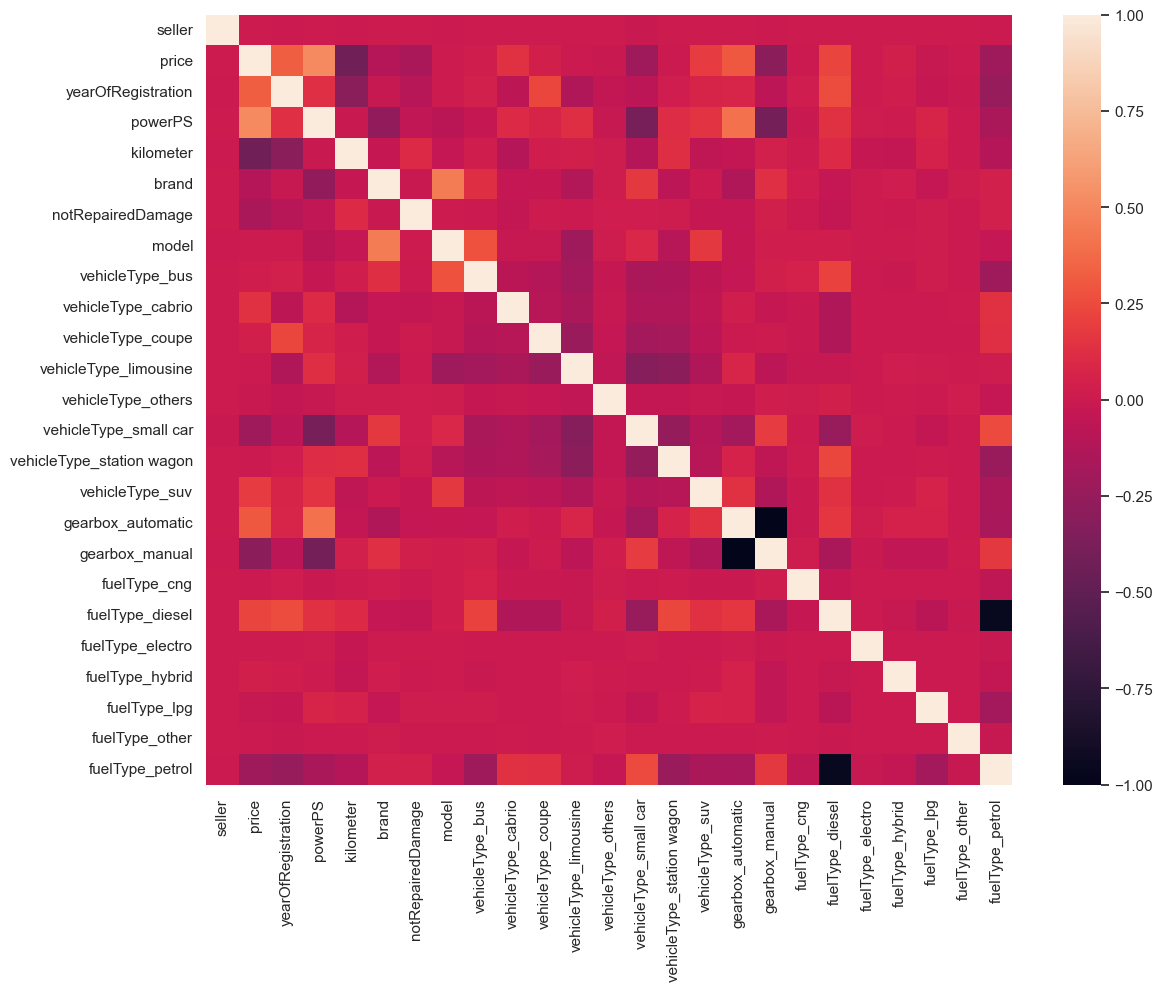

In [58]:
corr_matrix = data.corr()

sns.set(rc={'figure.figsize': (13, 10)})

sns.heatmap(corr_matrix, annot=False)

## **Делим данные**

In [59]:
X = data.drop(columns=['price'])
Y = data['price']

# **Разделение на тренеровочную и тестовую выборку**

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

# **Выбор модели**

## **LinearRegression**

In [61]:
model_LR = LinearRegression()

model_LR.fit(X_train, Y_train)

pred_model_LR = model_LR.predict(X_test)

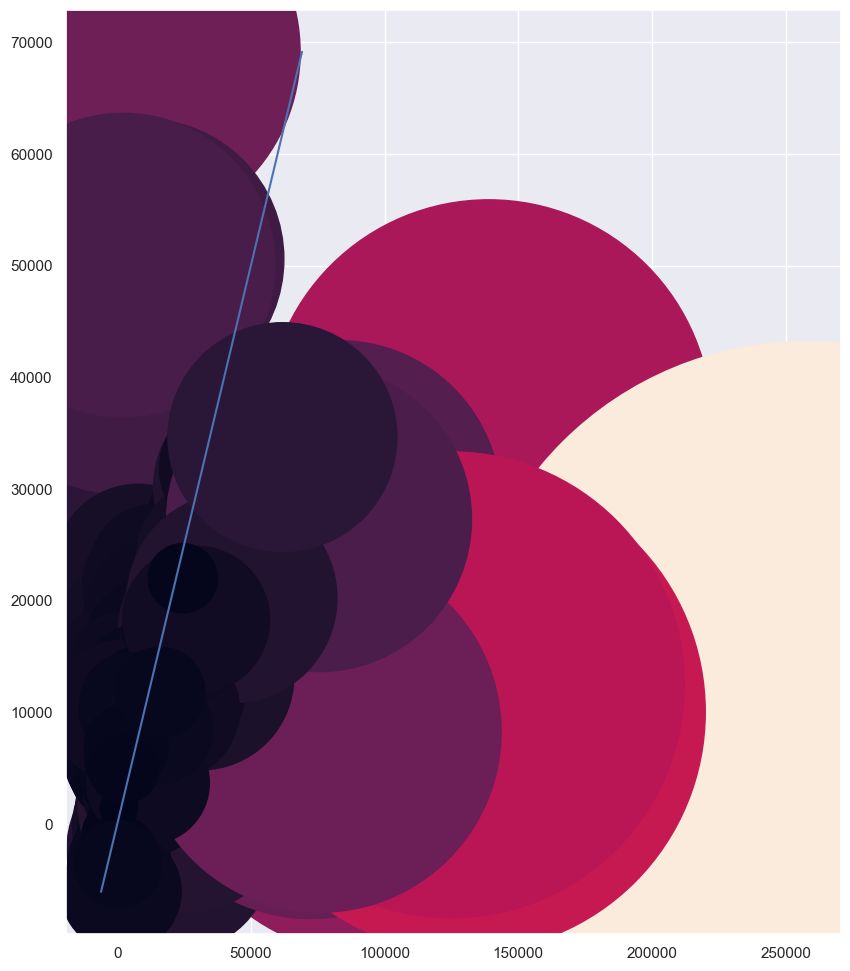

In [93]:
test_predictions = np.array(pred_model_LR)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(10, 12))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [62]:
result_pred(pred_model_LR, Y_test)

mean_squared_error: 6615.252485120356
mean_absolute_error: 2959.105934486872
median_absolute_error: 1907.0371250189492
r2_score: 0.42416683307529424


In [63]:
model_LR_pereb = LinearRegression()

params = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1],
    'positive': [True, False]
}

# создадим объект GridSearchCV
search_model_LR = GridSearchCV(model_LR_pereb, params, n_jobs=-1, cv=5, refit=True, scoring='neg_mean_absolute_error')

# запустим поиск
search_model_LR.fit(X_train, Y_train)

# выведем наилучшие параметры
print(search_model_LR.best_params_)

# применяем параметры
search_model_LR = search_model_LR.best_estimator_

prediction_search_model_LR = search_model_LR.predict(X_test)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}


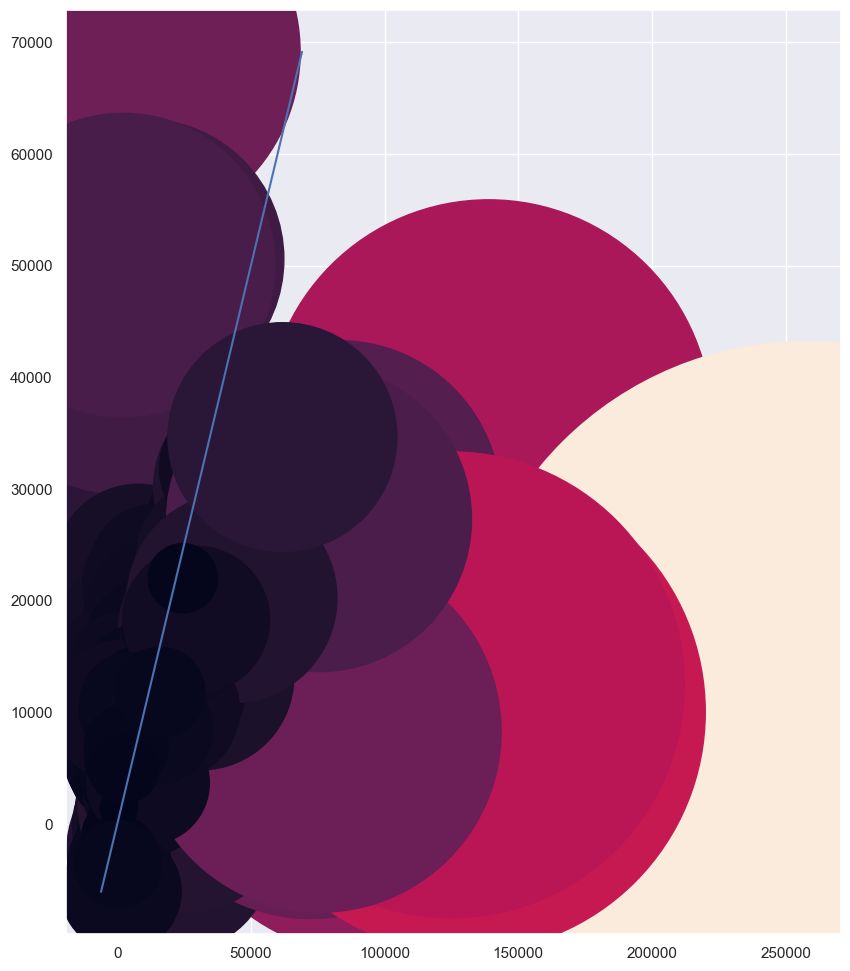

In [94]:
test_predictions = np.array(prediction_search_model_LR)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(10, 12))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [64]:
result_pred(prediction_search_model_LR, Y_test)

mean_squared_error: 6615.252485120356
mean_absolute_error: 2959.105934486872
median_absolute_error: 1907.0371250189492
r2_score: 0.42416683307529424


## **CatBoostRegressor**

In [65]:
model_CBR = CatBoostRegressor()

model_CBR.fit(X_train, Y_train, verbose=500)

predcit_model_CBR = model_CBR.predict(X_test)

Learning rate set to 0.07204
0:	learn: 7279.8865468	total: 138ms	remaining: 2m 17s
500:	learn: 2261.4122194	total: 1.9s	remaining: 1.89s
999:	learn: 1964.6164602	total: 3.63s	remaining: 0us


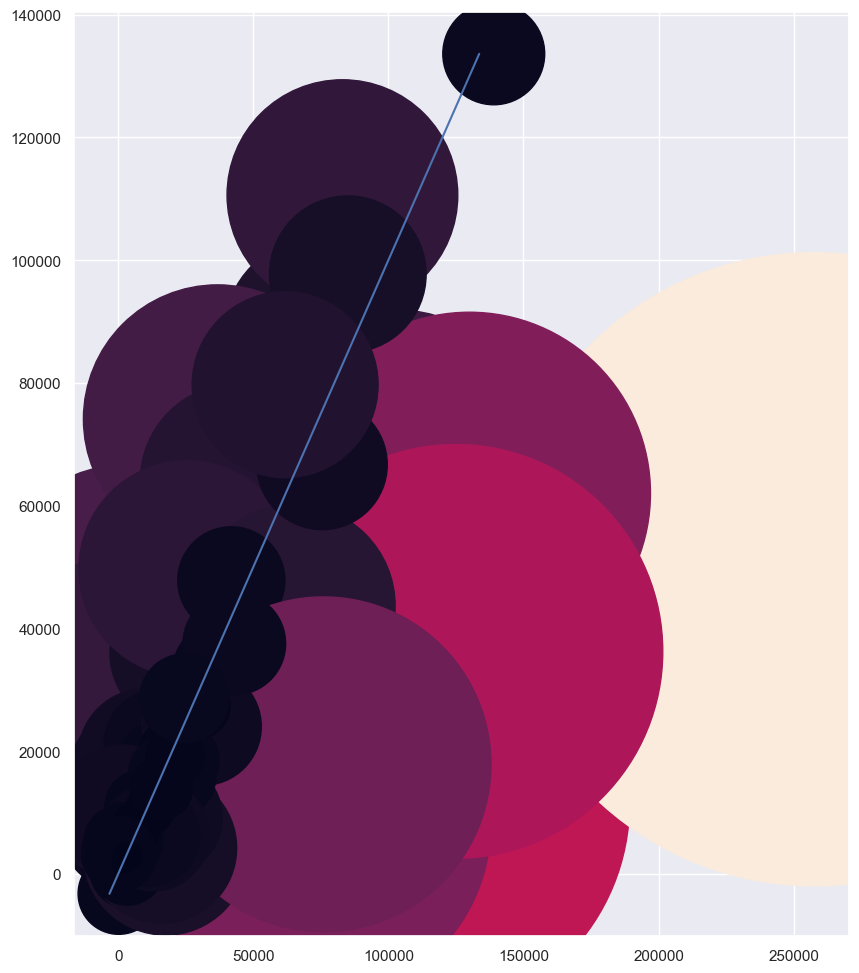

In [95]:
test_predictions = np.array(predcit_model_CBR)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(10, 12))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [66]:
result_pred(predcit_model_CBR, Y_test)

mean_squared_error: 4376.77846035563
mean_absolute_error: 1416.6625017647946
median_absolute_error: 704.7556020431457
r2_score: 0.7479347627395738


In [67]:
model_search_CBR = CatBoostRegressor(iterations=7001,
                                     rsm=1,
                                     early_stopping_rounds=100,
                                     grow_policy='Depthwise',
                                     depth=6,
                                     loss_function='RMSE',
                                     eval_metric='RMSE',
                                     l2_leaf_reg=15,
                                     learning_rate=0.05,
                                     border_count=300,
                                     verbose=1000,
                                     task_type='GPU'
                                     )

model_search_CBR.fit(X_train, Y_train)

0:	learn: 7364.7974029	total: 7.77ms	remaining: 54.4s
1000:	learn: 1977.5799889	total: 3.53s	remaining: 21.2s
2000:	learn: 1675.2354588	total: 7.41s	remaining: 18.5s
3000:	learn: 1515.4566780	total: 11.8s	remaining: 15.8s
4000:	learn: 1409.1722162	total: 16.4s	remaining: 12.3s
5000:	learn: 1330.6452238	total: 20.3s	remaining: 8.14s
6000:	learn: 1269.3698214	total: 24.2s	remaining: 4.03s
7000:	learn: 1220.3907000	total: 27.9s	remaining: 0us


In [68]:
pred_model_search_CBR = model_search_CBR.predict(X_test)

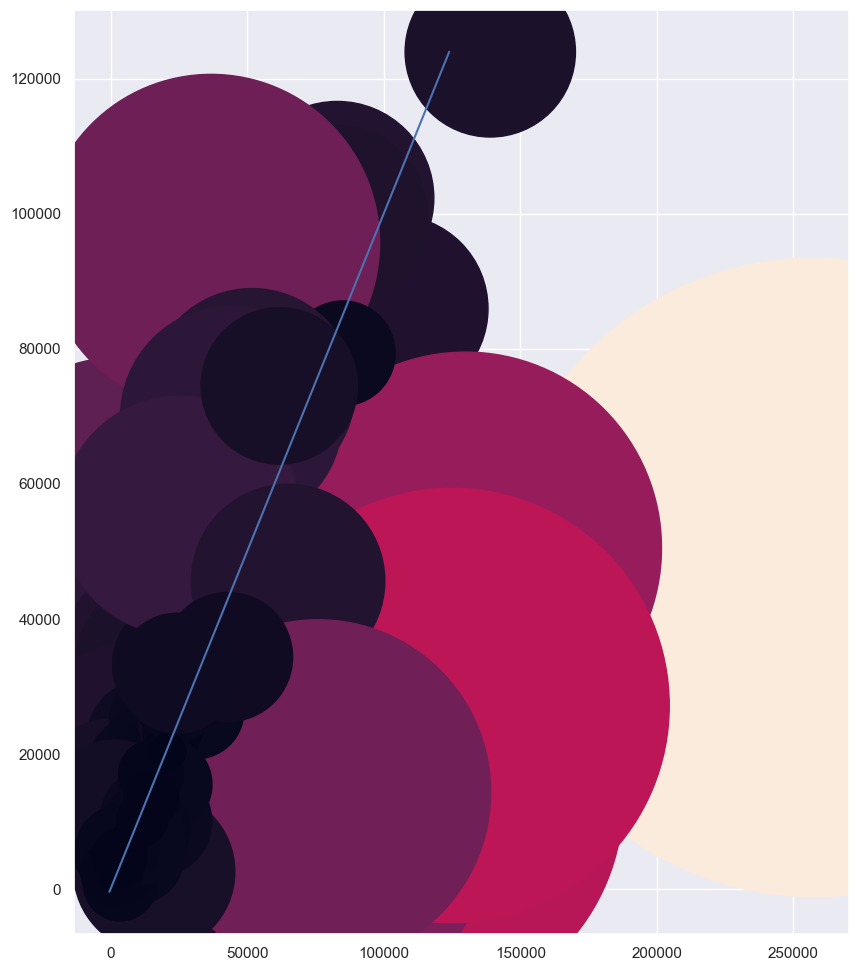

In [96]:
test_predictions = np.array(pred_model_search_CBR)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(10, 12))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [69]:
result_pred(pred_model_search_CBR, Y_test)

mean_squared_error: 4498.108581826335
mean_absolute_error: 1368.8822725896546
median_absolute_error: 645.0549582031258
r2_score: 0.7337658902110056


## **LassoCV**

In [70]:
LCV = LassoCV()

LCV.fit(X_train, Y_train)

prediction_LCV = LCV.predict(X_test)

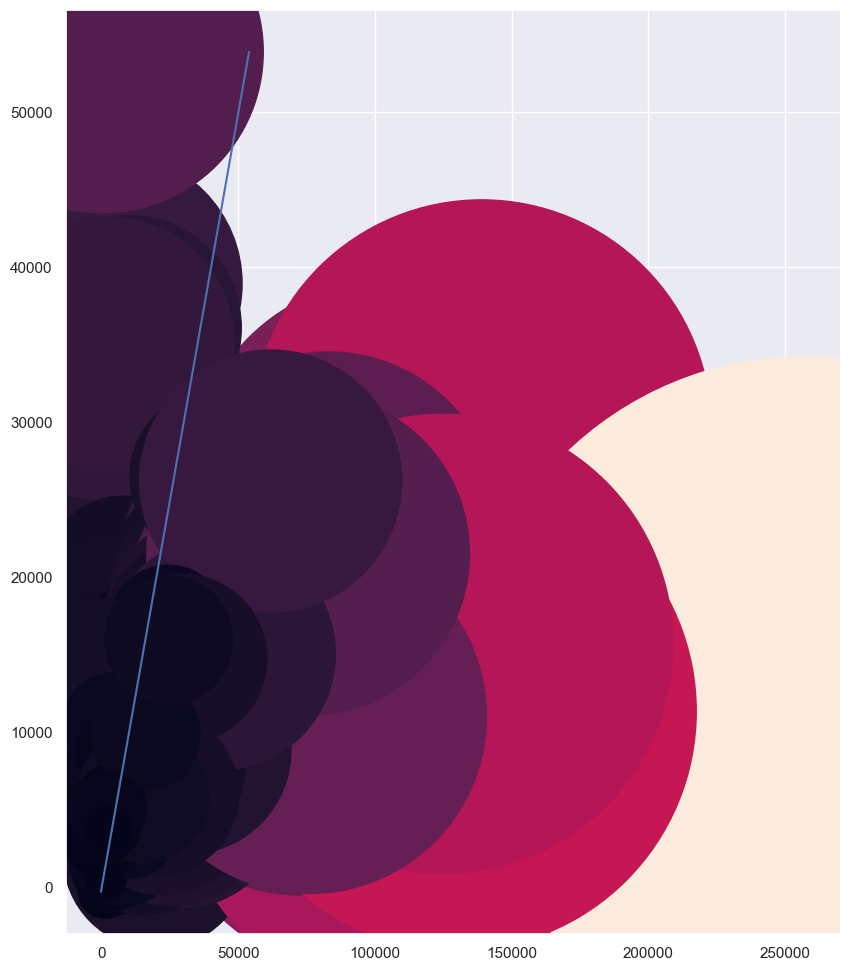

In [97]:
test_predictions = np.array(prediction_LCV)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(10, 12))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [71]:
result_pred(prediction_LCV, Y_test)

mean_squared_error: 7122.975375132144
mean_absolute_error: 3463.6206843401574
median_absolute_error: 2196.3365730262212
r2_score: 0.33238403671305294


## **RidgeCV**

In [72]:
RCV = RidgeCV()

RCV.fit(X_train, Y_train)

prediction_RCV = RCV.predict(X_test)

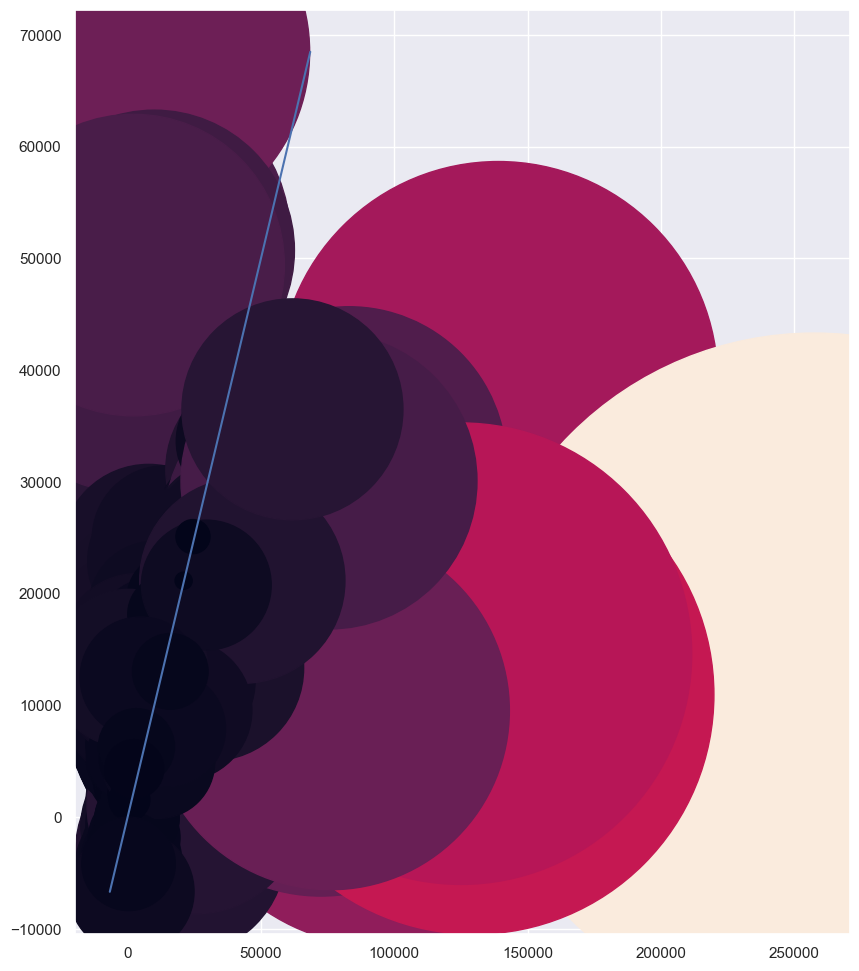

In [98]:
test_predictions = np.array(prediction_RCV)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(10, 12))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [73]:
result_pred(prediction_RCV, Y_test)

mean_squared_error: 6678.619537477392
mean_absolute_error: 3152.635476294661
median_absolute_error: 2107.921411878109
r2_score: 0.41308226370331647


In [74]:
search_RCV = RidgeCV(cv=50)

search_RCV.fit(X_train, Y_train)

prediction_search_RCV = search_RCV.predict(X_test)

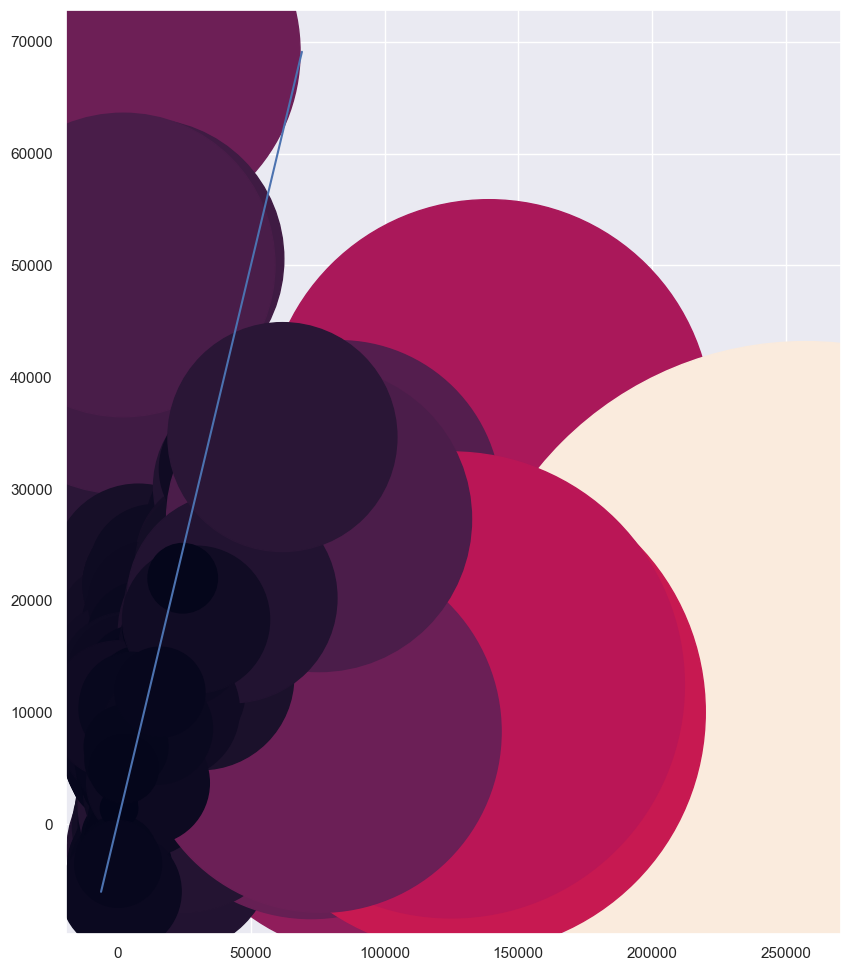

In [99]:
test_predictions = np.array(prediction_search_RCV)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(10, 12))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [75]:
result_pred(prediction_RCV, Y_test)

mean_squared_error: 6678.619537477392
mean_absolute_error: 3152.635476294661
median_absolute_error: 2107.921411878109
r2_score: 0.41308226370331647


## **ElasticNetCV**

In [76]:
ENCV = ElasticNetCV()

ENCV.fit(X_train, Y_train)

prediction_ENCV = ENCV.predict(X_test)

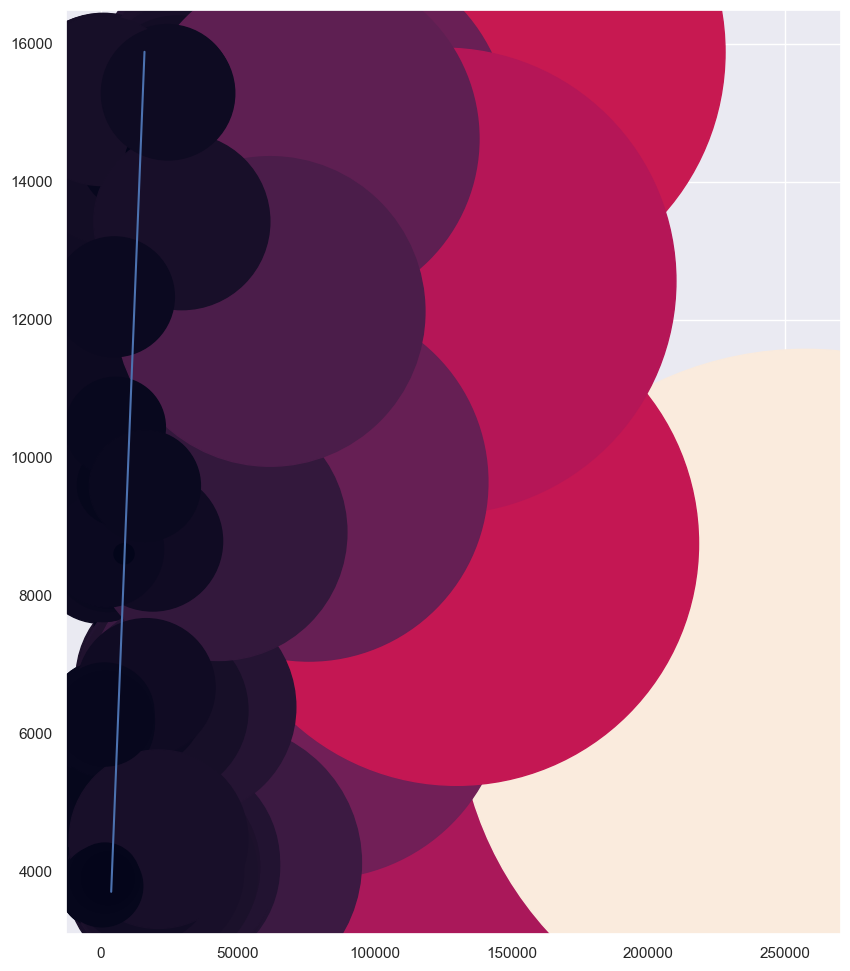

In [103]:
test_predictions = np.array(prediction_ENCV)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(10, 12))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [77]:
result_pred(prediction_ENCV, Y_test)

mean_squared_error: 7988.950561821704
mean_absolute_error: 4311.164453785641
median_absolute_error: 2949.8027337932963
r2_score: 0.16018564491623366


In [78]:
ENCV = ElasticNetCV()

params = {
    'l1_ratio': [0.6, 0.8, 0.5],
    'eps': [1e-7, 1e-8, 1e-10],
    'n_alphas': [50, 100, 150],
    'max_iter': [50, 100, 150],
    'tol': [1e-05, 1e-2, 1e-04],
    'random_state': [25, 45],
    'selection': ['random', 'cyclic']
}

search_ENCV = GridSearchCV(ENCV, params, n_jobs=-1, cv=5, refit=True, scoring='neg_mean_absolute_error')

# запустим поиск
search_ENCV.fit(X_train, Y_train)

# выведем наилучшие параметры
print(search_ENCV.best_params_)

# применяем параметры
search_ENCV = search_ENCV.best_estimator_

prediction_search_ENCV = search_ENCV.predict(X_test)

{'eps': 1e-08, 'l1_ratio': 0.8, 'max_iter': 50, 'n_alphas': 50, 'random_state': 25, 'selection': 'cyclic', 'tol': 1e-05}


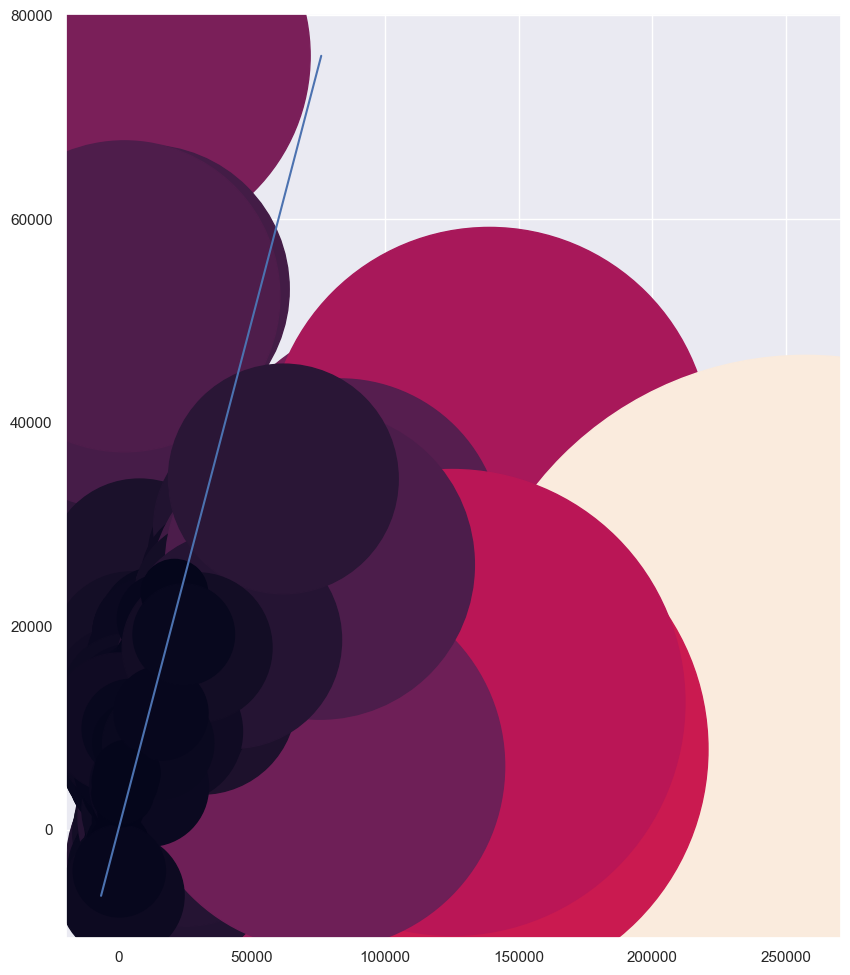

In [104]:
test_predictions = np.array(prediction_search_ENCV)
area = abs(Y_test - test_predictions)
plt.figure(figsize=(10, 12))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [79]:
result_pred(prediction_search_ENCV, Y_test)

mean_squared_error: 6696.077167852522
mean_absolute_error: 2950.9009096393033
median_absolute_error: 1813.5888772760518
r2_score: 0.41000989690601686


## **Сравнимаем результаты**

In [80]:
comparison_table = pd.DataFrame(result_table([pred_model_LR,
                                              prediction_search_model_LR,
                                              predcit_model_CBR,
                                              pred_model_search_CBR,
                                              prediction_LCV,
                                              prediction_RCV,
                                              prediction_search_RCV,
                                              prediction_ENCV,
                                              prediction_search_ENCV],
                                              Y_test,
                                              subcol='models',
                                              valueSubCol=['model_LR', 'search_model_LR',
                                                            'model_CBR', 'model_search_CBR',
                                                              'LCV', 'RCV', 'search_RCV',
                                                                'ENCV', 'search_ENCV']))

In [81]:
comparison_table

,models,mean_squared_error,mean_absolute_error,median_absolute_error,r2_score
0,model_LR,6615.252485,2959.105934,1907.037125,0.424167
1,search_model_LR,6615.252485,2959.105934,1907.037125,0.424167
2,model_CBR,4376.778460,1416.662502,704.755602,0.747935
3,model_search_CBR,4498.108582,1368.882273,645.054958,0.733766
4,LCV,7122.975375,3463.620684,2196.336573,0.332384
5,RCV,6678.619537,3152.635476,2107.921412,0.413082
6,search_RCV,6615.294094,2958.176369,1907.333645,0.424160
7,ENCV,7988.950562,4311.164454,2949.802734,0.160186
8,search_ENCV,6696.077168,2950.900910,1813.588877,0.410010


### **Из всех моделей хорошо себя показали model_search_CBR и model_CBR**

## **Обучим на всех данных и затестим**

In [82]:
model_CBR.fit(X, Y, verbose=500)

Learning rate set to 0.073914
0:	learn: 7459.0149643	total: 3.94ms	remaining: 3.94s
500:	learn: 2439.4580807	total: 2s	remaining: 2s
999:	learn: 2097.2480658	total: 4.12s	remaining: 0us


ValueError: x and y must be the same size

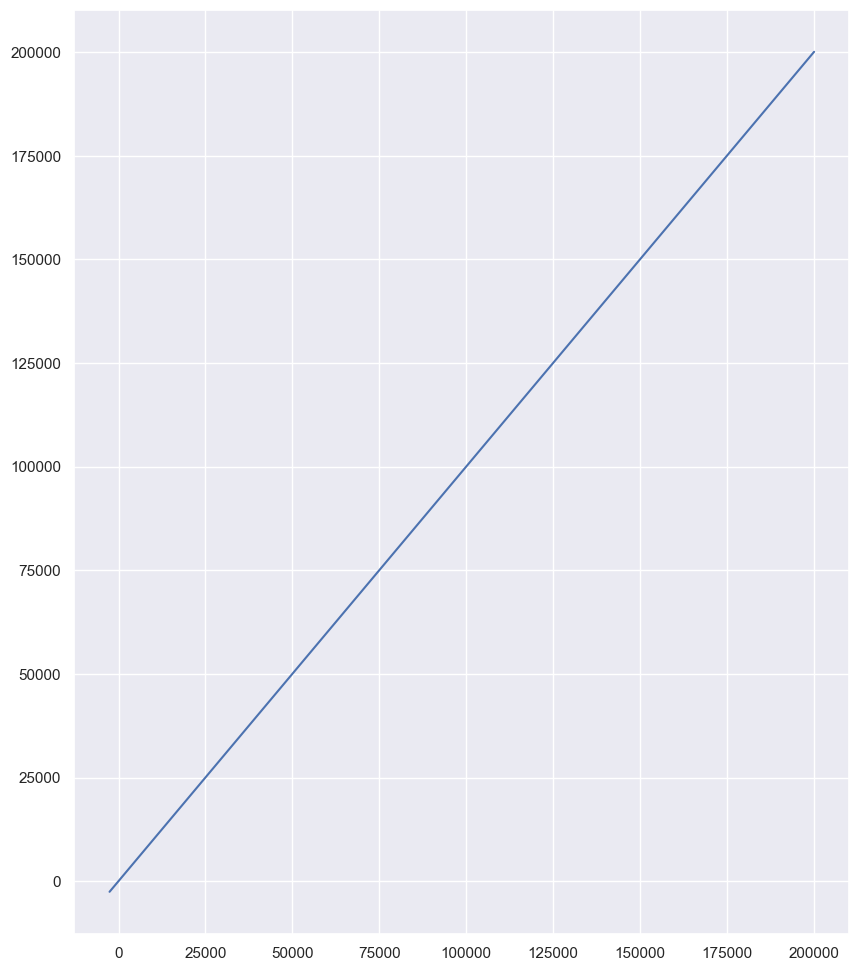

In [105]:
test_predictions = np.array(model_CBR.predict(X))
area = abs(Y - test_predictions)
plt.figure(figsize=(10, 12))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [83]:
model_search_CBR.fit(X, Y)

0:	learn: 7543.3080022	total: 7.56ms	remaining: 52.9s
1000:	learn: 2104.5531429	total: 4.09s	remaining: 24.5s
2000:	learn: 1785.1971362	total: 8.11s	remaining: 20.3s
3000:	learn: 1617.8508035	total: 12.4s	remaining: 16.5s
4000:	learn: 1511.6361652	total: 17s	remaining: 12.7s
5000:	learn: 1436.5812859	total: 22.3s	remaining: 8.91s
6000:	learn: 1379.8018208	total: 27.8s	remaining: 4.63s
7000:	learn: 1335.2235193	total: 33.4s	remaining: 0us


In [ ]:
test_predictions = np.array(model_CBR.predict(X))
area = abs(Y - test_predictions)
plt.figure(figsize=(10, 12))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(Y_test, test_predictions, marker='o', s=area, c=area)

In [84]:
comparison_table = pd.DataFrame(result_table([model_CBR.predict(X),
                                              model_search_CBR.predict(X)],
                                              Y,
                                              subcol='models',
                                              valueSubCol=['model_CBR', 'model_search_CBR']))

In [85]:
comparison_table

,models,mean_squared_error,mean_absolute_error,median_absolute_error,r2_score
0,model_CBR,2097.248066,1188.661198,688.469518,0.927355
1,model_search_CBR,1335.223501,829.241634,536.834173,0.970555


## **Сохраним лучшую модель**

In [ ]:
with open('bestModel.bf', '+wb') as bestModel:
    pickle.dump(model_search_CBR, bestModel)